PLACE CELLS

Mouse is running on a thread mill. The thread mill is colored by patterns, so that the mouse knows where she is. Place cell activity is monitored by calcium imaging. Only reward stimuli is present in this data. Using UMAP, activity of the place cells is mapped onto a circle in 3d space. The manifold is then colored by position on the threadmill, so we can infer her position directly from the circle. (No train/test split in this notebook, only one mouse.)  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import umap
from mpl_toolkits.mplot3d import Axes3D
from ripser import Rips
import plotly.graph_objs as go
from scipy.signal import correlate
from scipy.signal import find_peaks
from plotly.subplots import make_subplots
import matplotlib.cm as cm

import sys

sys.path.append('/home/martin/Coding/Bakalarka/structure_index')
from structure_index import compute_structure_index, draw_graph

In [3]:
pathR3 = '/home/martin/Data/processed_magdeburg_data/Reward/3'

In [4]:
def bin_multiple_array(array, bin_size):
    # Reshape 1D array to 2D array
    if array.ndim == 1:
        array = array.reshape(1, -1)  

    num_neurons, num_timepoints = array.shape

    num_bins = num_timepoints // bin_size

    binned_multiple_array = np.zeros((num_neurons, num_bins))

    for bin_idx in range(num_bins):
        start_idx = bin_idx * bin_size
        end_idx = min((bin_idx + 1) * bin_size, num_timepoints)
        binned_multiple_array[:, bin_idx] = np.mean(array[:, start_idx:end_idx], axis=1)

    return np.squeeze(binned_multiple_array)

def load_var(path):
    int_df = pd.read_csv(os.path.join(path, 'int.csv'))
    signal_df = pd.read_csv(os.path.join(path, 'signal.csv'))
    action_df = pd.read_csv(os.path.join(path, 'action.csv'))
    pos = action_df['pos']
    v = action_df['v']
    licking = action_df['licking']
    signal = signal_df['S'].values.reshape(int_df['num_neurons'].values[0], int_df['num_times'].values[0])
    return signal, pos, v, licking

In [81]:
#get signal
def get_signal(path, bin_size, sd=True, only_velocity=False):
    
    #load signals
    signal, pos, v, licking = load_var(path)
    
    #get rid of empty neurons
    std_dev = np.std(signal, axis=1, keepdims=True)
    invalid_neurons = [i for i, v in enumerate(std_dev) if v == 0]
    valid_neurons_mask = np.logical_not(np.isin(np.arange(signal.shape[0]), invalid_neurons))
    signal = signal[valid_neurons_mask]

    #normalize
    if sd:
        std_dev = std_dev[valid_neurons_mask]
        mean = np.mean(signal, axis=1, keepdims=True)
        signal = (signal - mean) / std_dev
    
    #binning in time
    signal = bin_multiple_array(signal, bin_size)
    pos = bin_multiple_array(np.array(pos), bin_size)
    v = bin_multiple_array(np.array(v), bin_size)
    
    #use only times when mouse moving
    if only_velocity:
        running_indices = np.where(np.array(v) > 2)[0]
        position = np.array(pos)[running_indices]
        signal = np.squeeze(signal[:, running_indices])
        licking = np.array(licking)[running_indices]

    return signal, pos, licking

#calculate pca
def get_pca_signals(signals, pca_components):
    if not isinstance(pca_components, list):
        pca_components = [pca_components]  # Convert single value to list
    
    pca_signals = []
    for signal in signals:
        pca = PCA(n_components=max(pca_components) + 1)
        pca_signal = pca.fit_transform(signal.T).T
        pca_signal = pca_signal[pca_components]  # Extract components specified in pca_components list
        pca_signals.append(pca_signal)

    return pca_signals

#get umap embedding
def get_umap_embedding(signals):
    reducer = umap.UMAP(n_components=3)
    embedding = np.array([])

    for signal in signals:
        temp_embedding = reducer.fit_transform(signal.T)
        embedding = temp_embedding if not embedding.any() else np.concatenate((embedding, temp_embedding), axis=0)

    return embedding

def create_embedding_plot(embedding_data, color_scale, colorscale):
    trace_embedding = go.Scatter3d(
        x=embedding_data[:, 0],
        y=embedding_data[:, 1],
        z=embedding_data[:, 2],
        mode='markers',
        marker=dict(size=2, color=color_scale, colorscale=colorscale, colorbar=dict(title='Pos')),
    )

    layout_embedding = go.Layout(
        scene=dict(
            xaxis=dict(title='Dimension 1'),
            yaxis=dict(title='Dimension 2'),
#             zaxis=dict(title='Dimension 3')
        )
    )

    return go.Figure(data=[trace_embedding], layout=layout_embedding)

#find rotation matrix of vector a to b
def rotation_matrix_from_vectors(a, b):
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + np.dot(kmat, kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def align_point_cloud(point_cloud):
    # Calculate center
    center = np.mean(point_cloud, axis=0)

    # Center the point cloud
    centered_point_cloud = point_cloud - center

    # Perform PCA to get the normal vector
    pca = PCA(n_components=3)
    pca.fit(centered_point_cloud)
    normal = pca.components_[2]

    # Define the z-axis
    z_axis = np.array([0, 0, 1])

    # Calculate rotation matrix
    rotation_matrix = rotation_matrix_from_vectors(normal, z_axis)

    # Apply rotation to align the point cloud
    aligned_point_cloud = np.dot(centered_point_cloud, rotation_matrix.T)

    return aligned_point_cloud
    
def create_embedding_plot_2d(embedding, color_scale):
    plt.scatter(embedding[:, 0], embedding[:, 1], c=color_scale, cmap='twilight')

In [82]:
signal, pos, _ = get_signal(pathR3, 50, only_velocity=False)
# pca_signal = get_pca_signals(signal)

embedding = get_umap_embedding([signal])


In [55]:
aligned_point_cloud = align_point_cloud(embedding)


In [56]:
fig = create_embedding_plot(aligned_point_cloud, pos, 'twilight')
fig.show()

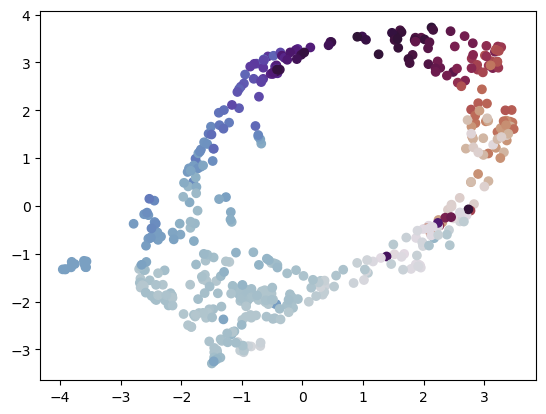

In [77]:
create_embedding_plot_2d(aligned_point_cloud,pos)

In [57]:
print(aligned_point_cloud.shape)

(479, 3)


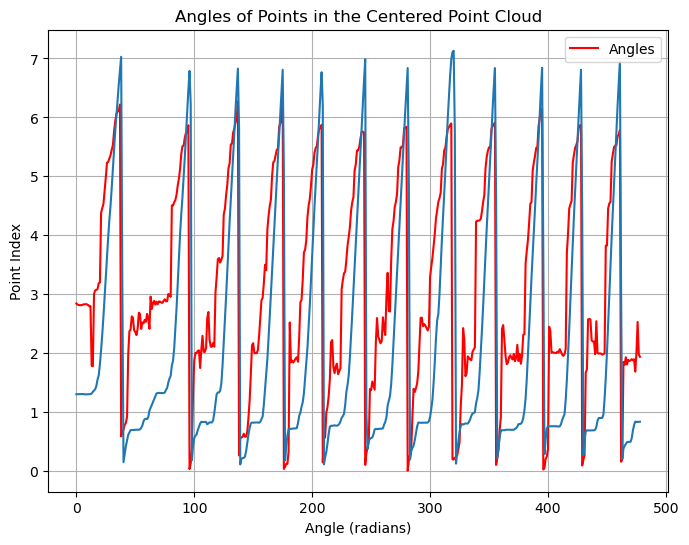

In [79]:
#very basic decoding based on parametrization of the circle in the 3d space by polar coordinates
relative_angles = np.arctan2(-aligned_point_cloud[:, 1], aligned_point_cloud[:, 0])
relative_angles = (relative_angles) % (2*np.pi)
plt.figure(figsize=(8, 6))
plt.plot(relative_angles, c='r', label='Angles')
plt.plot(pos/50)
plt.xlabel('Angle (radians)')
plt.ylabel('Point Index')
plt.title('Angles of Points in the Centered Point Cloud')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
correlation = np.corrcoef(pos, relative_angles)[0, 1]
print("Correlation between signal_pos and signal_relative_angles:", correlation)

Correlation between signal_pos and signal_relative_angles: 0.7055409262495358
